# Spark's ML Capabilities - Latent Dirilecht Allocation

## LDA - What is it?

LDA uses a generative model to automatically discover topics within an article. The algrotihm regards each article as a mixture of topics, and that the words within the article belong to a particular topic.

For example, suppose you have the following set of sentences:

* I like to eat broccoli and bananas.
* I ate a banana and spinach smoothie for breakfast.
* Chincillas and kittens are cute.
* My sister adopted a kitten yesterday.
* Look at this cute hamster munching on a piece of broccoli.

LDA might product something like:
* **Sentences 1 and 2:** 100% Topic A
* **Sentences 3 and 4:** 100% Topic B
* **Sentence 5**: 60% Topic A, 40% Topic B
* **Topic A**: 30% broccoli, 15% bananas, 10% breakfast, 10% munching, ... (A person or algorithm would thereafter interpret this topic to be about food.
* **Topic B**: 20% chinchillas, 20% kittens, 20% cute, ... 


## Implementing the Algorithm in PySpark

We begin our code with some imports.

In [16]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StopWordsRemover, CountVectorizer, CountVectorizerModel, RegexTokenizer, Tokenizer
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import string
import re
pylab.rcParams['figure.figsize'] = 12, 12

Next, we initialize our Sparksession. We communicate with Spark (and thus the cluster) via the Sparksession.

In [17]:
spark = SparkSession.builder.appName("LDA").getOrCreate()
# nltk.download('all')

We need to provide the file location in the Gcloud bucket to read it in to a `DataFrame`.

In [18]:
bucket_location = "gs://dataproc-04d7eda2-db56-484f-aba4-5db51f8b3d84-us/"
#file_location = "mimic/NOTEEVENTS_DEMO_PROCESSED.csv"
file_location = "mimic/NOTEEVENTS_DEMO_PROCESSED.csv"
notes_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("delimiter", ",").load(bucket_location + file_location).na.fill(-1)

## Preprocessing the Data

Next, we need to preprocess the text data. First, let's define a function for removing any unwanted characters and implement it as `UserDefinedFunction`, or `udf`.

In [4]:
# Courtesy: https://mingchen0919.github.io/learning-apache-spark/nlpC.html
def remove_features(data_str):
    # compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    punc_re = re.compile('[%s]' % re.escape(string.punctuation))
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
    # convert to lowercase
    data_str = data_str.lower()
    # remove hyperlinks
    data_str = url_re.sub(' ', data_str)
    # remove @mentions
    data_str = mention_re.sub(' ', data_str)
    # remove puncuation
    data_str = punc_re.sub(' ', data_str)
    # remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
    # remove non a-z 0-9 characters and words shorter than 3 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word) and len(word) > 2:
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
    return cleaned_str

remove_features_udf = udf(remove_features, StringType())

Next, let's filter out any notes with errors and then use the above `udf` to remove the characters we specified.

In [5]:
small_notes_df = notes_df.filter(notes_df['iserror'] != '1').select(notes_df['rowid'], remove_features_udf(notes_df['text'].cast("string")).alias('text'))
small_notes_df.persist()
small_notes_df.show(5)

+-----+--------------------+
|rowid|                text|
+-----+--------------------+
|  227|admission date di...|
|  868|admission date di...|
|  869|admission date di...|
|  870|admission date di...|
|  906|admission date di...|
+-----+--------------------+
only showing top 5 rows



We now need to group together the inflected forms of the words so we can analyze them as a single item - a process known as lemmatizaiton. We use a similar approach as when the unwanted characters were removed.

In [19]:
def lemmatize(data_str):
    # expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    tagged_words = pos_tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str

lemmatize_udf = udf(lemmatize, StringType())
lemmatized_notes_df = small_notes_df.withColumn("lemmatized", lemmatize_udf(small_notes_df['text']))

We use a Spark `RegexTokenizer` to break up the strings into separate words. We then define a `udf` to implement a string length filter.

In [7]:
tokenizer = RegexTokenizer(inputCol="lemmatized", outputCol="tokens", pattern="\\W")

def length_filter(tokens):
    return [token for token in tokens if (len(token) > 7 and len(token) < 25)]

schema1 = ArrayType(StringType())
length_filter_udf = udf(length_filter, schema1)
notes_tokenized = tokenizer.transform(lemmatized_notes_df)
notes_tokenized = notes_tokenized.select(notes_tokenized['rowid'], length_filter_udf(notes_tokenized["tokens"]).alias("tokens"))

After tokenizing the inputs, we use a Spark `StopWordsRemover` to clean up the data by removing common English words.

In [8]:
default_english = StopWordsRemover().getStopWords()
common_words = ["admission", "discharge"] + default_english
remover = StopWordsRemover(inputCol="tokens", stopWords=common_words, outputCol="tokens_filtered")
filtered_tokens = remover.transform(notes_tokenized)

In order to run a Machine Learning algorithm we need to transform the lists of words to word-count vectors of the form `Vector(vocabSize,Array(tokenIndices),Array(tokenCounts))`.

In [9]:
cv = CountVectorizer(inputCol="tokens_filtered", outputCol="features").fit(filtered_tokens)
token_counts = cv.transform(filtered_tokens)
token_counts.show(5)

+-----+--------------------+--------------------+--------------------+
|rowid|              tokens|     tokens_filtered|            features|
+-----+--------------------+--------------------+--------------------+
|  227|[admission, disch...|[medicine, oncolo...|(8320,[2,5,6,7,9,...|
|  868|[admission, disch...|[medicine, allerg...|(8320,[0,2,3,5,6,...|
|  869|[admission, disch...|[medicine, allerg...|(8320,[0,2,3,5,6,...|
|  870|[admission, disch...|[medicine, allerg...|(8320,[0,2,3,5,6,...|
|  906|[admission, disch...|[medicine, morphi...|(8320,[0,2,3,4,5,...|
+-----+--------------------+--------------------+--------------------+
only showing top 5 rows



In [10]:
feature_vectors = token_counts.select('rowid', 'features')

Finally, we run the LDA algorithm itself

In [11]:
lda = LDA().setK(3)
model = lda.fit(feature_vectors)

## Analyzing the Data

Let's look at how the word weights are distributed within each topic.

In [12]:
topics = model.describeTopics()

def indices_mapping(indices, vocab):
    return [vocab[i] for i in indices]

def make_indices_mapping(vocab):
    schema2 = ArrayType(StringType())
    return udf(lambda indices: indices_mapping(indices, vocab), schema2)

topics_with_words = topics.select(topics["topic"], make_indices_mapping(cv.vocabulary)(topics["termIndices"]).alias("terms"), topics["termWeights"])
topics_with_words.show(truncate=False)

+-----+------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|topic|terms                                                                                                             |termWeights                                                                                                                                                                                                                  |
+-----+------------------------------------------------------------------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Using Matpotlib, let's take a grahical approach to viewing the word weights in the first topic.

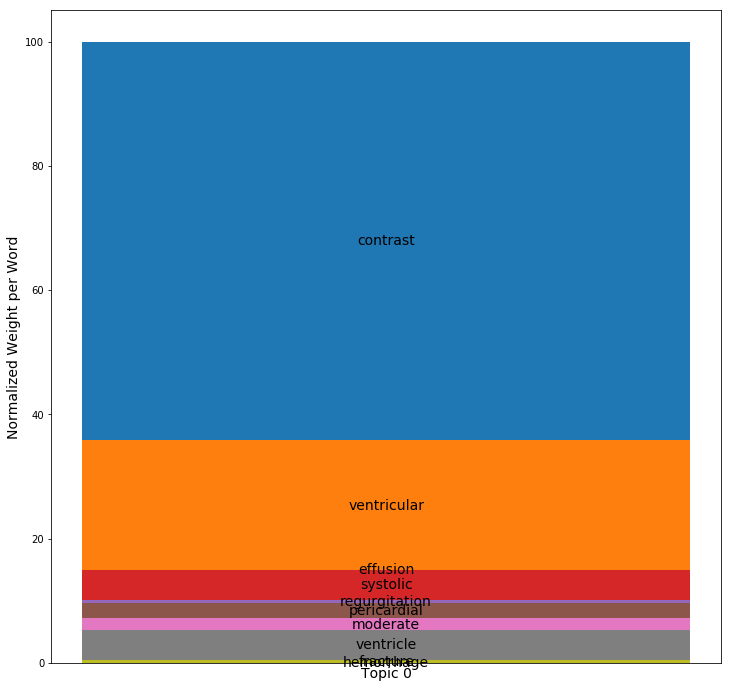

In [13]:
topics_with_words_pdf = topics_with_words.toPandas()
first_topic = topics_with_words_pdf.iloc[0]
min_first_topic = min(first_topic.termWeights)
max_first_topic = max(first_topic.termWeights)


for i in range(len(first_topic.terms)):
    plt.bar(0, (first_topic.termWeights[i] - min_first_topic)/(max_first_topic - min_first_topic) * 100, label=first_topic.terms[i])

ax = plt.axes()
rects = ax.patches
rectangle_tops = []
for rect in rects:
    rectangle_tops.append(rect.get_height())
    
rectangle_tops.append(0.0)
i = 1
for (rect, label) in zip(rects, first_topic.terms):
    height = rect.get_height()
    width = rect.get_width()
    plt.text(rect.get_x() + width/2, (height + rectangle_tops[i])/2, label, ha='center', va='center', size=14)
    i = i + 1

    
# plt.legend(bbox_to_anchor=(1.05, 1), loc="best", ncol=1)
plt.xlabel("Topic 0", size=14)
plt.ylabel("Normalized Weight per Word", size=14)
plt.tick_params(
    axis='x',
    which='both',
    bottom='off',
    top='off',
    labelbottom='off'
)


plt.figure(figsize=(100, 100), dpi=100)
plt.show()
plt.close()



Next, let's analyze the topic distributions within two documents.

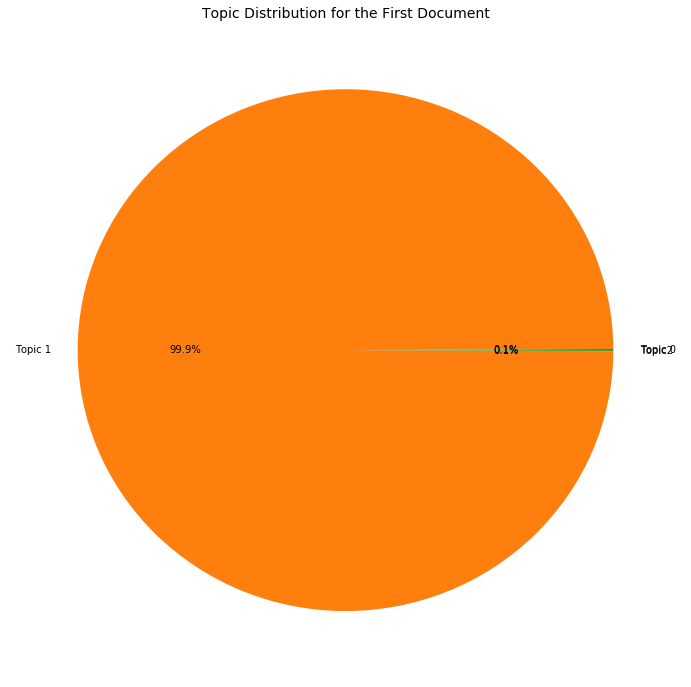

In [14]:
topic_distribution_pds = model.transform(feature_vectors).select("topicDistribution").toPandas()
first_document = topic_distribution_pds.iloc[0]
second_document = topic_distribution_pds.iloc[5421]

labels = ['Topic 0', 'Topic 1', 'Topic2']
plt.pie(first_document.topicDistribution, labels=labels, autopct='%1.1f%%')
plt.title("Topic Distribution for the First Document", size=14)
plt.show()
plt.close()

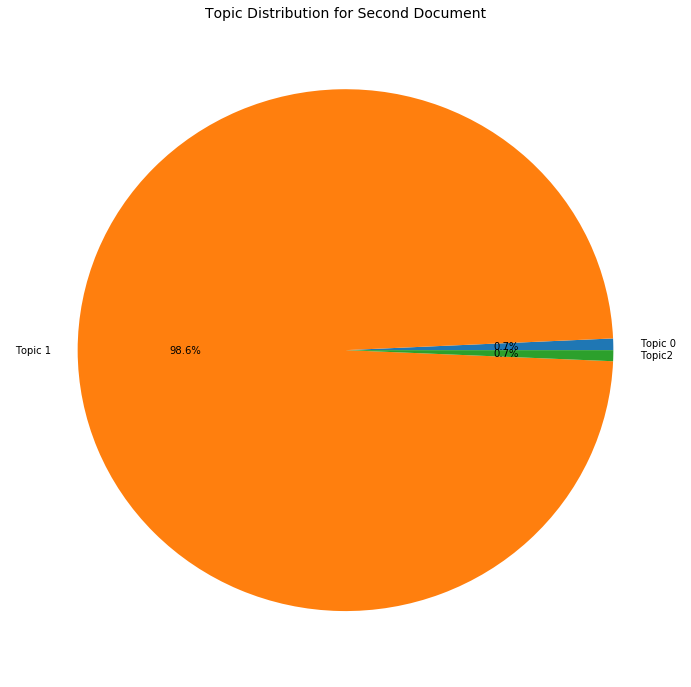

In [15]:
plt.pie(second_document.topicDistribution, labels=labels, autopct='%1.1f%%')
plt.title("Topic Distribution for Second Document",size=14)
plt.show()
plt.close()